## Fake News Assignmet


## Importing needed libraries 

In [54]:
#importing Libraries------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from string import punctuation
%matplotlib inline
from collections import Counter
from collections import defaultdict
import re
import os



#NLTK related--------------------------------------------
import nltk
from nltk import collocations, pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


#sklearn related------------------------------------------
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.svm import SVC



import seaborn as sns


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/madisubaiti/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/madisubaiti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/madisubaiti/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/madisubaiti/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Importing Train and Test Datasets

In [82]:
df_training = pd.read_csv('fake_or_real_news_training.csv')
df_test = pd.read_csv('fake_or_real_news_test.csv')
df_training.text.count()

3999

In [83]:
df_training.head()

,ID,title,text,label,X1,X2
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN


In [84]:
df_test.head()

,ID,title,text
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...
1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...
2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...
3,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...
4,662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...


## Counting number of values in "Title" and "Text" and finding the StopWords

In [85]:
 # functions
    
def lexical_diversity(text):
    return len(set(text)) / len(text)

stop = stopwords.words('english')
punctuation += '´΄’…“”–—―»«'

In [86]:
#Training
df_training['count_title'] = df_training.title.apply(lambda x: len(x.split(" ")))
df_training['count_text'] = df_training.text.apply(lambda x: len(x.split(" ")))
df_training['diversity'] = df_training.text.apply(lambda x: lexical_diversity(x))
df_training['stopwords'] = df_training.text.apply(lambda x: len([x for x in x.split() if x in stop]))

#Test 
df_test['count_title'] = df_test.title.apply(lambda x: len(x.split(" ")))
df_test['count_text'] = df_test.text.apply(lambda x: len(x.split(" ")))
df_test['diversity'] = df_test.text.apply(lambda x: lexical_diversity(x))
df_test['stopwords'] = df_test.text.apply(lambda x: len([x for x in x.split() if x in stop]))



## Analyzing the Real and Fake News distribution
 ### Labels WordCount

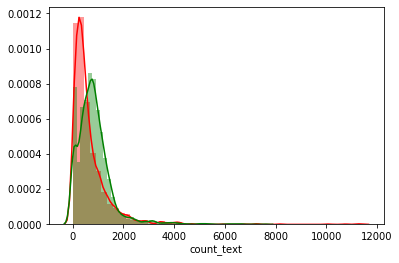

In [60]:
sns.distplot(df_training[df_training["label"]=="FAKE"]["count_text"], color = "r",label = "Fake News")
sns.distplot(df_training[df_training["label"]=="REAL"]["count_text"], color = "g", label = "Real News")

It seems here that news tweets with more words show a tendency of being Fake News. The range of word counts for Real News is a lot less than that of the Fake. 


### Title WordCount

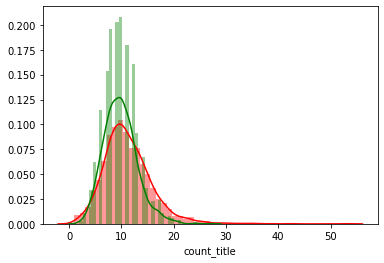

In [61]:
sns.distplot(df_training[df_training["label"]=="FAKE"]["count_title"], color = "r", label = "Fake news")
sns.distplot(df_training[df_training["label"]=="REAL"]["count_title"], color = "g", label = "Real news")

Fake News appears to have slightly longer titles than Real News in this scenario as well. 

### StopWords WordCount

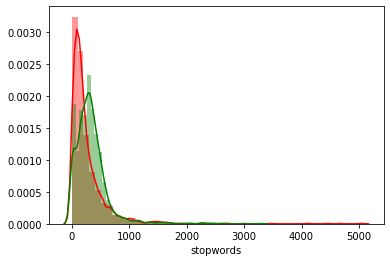

In [62]:
sns.distplot(df_training[df_training["label"]=="FAKE"]["stopwords"], color = "r", label = "Fake news")
sns.distplot(df_training[df_training["label"]=="REAL"]["stopwords"], color = "g", label = "Real news")

Fake News once again uses more stopwords in their articles than Real News

In conclusion, it is evident that Fake News use more words in general that Real News

# Data Cleaning
### Understanding the features

In [87]:
u_labels = df_training['label'].nunique()
u_X1 = df_training['X1'].nunique()
u_X2 = df_training['X2'].nunique()
u_text = df_training['text'].nunique()

print("We have ", u_labels, " lables when we should have only 2 in correspondence with the main lables: 'REAL' and 'FAKE'")
print("X1 is still a variable although it is not clear what it is, however it contains ", u_X1 ,"unique values while column X2 has", u_X2, "unique values")
print("The text column  was expected to have 3999 disctinct texts but we found that there are ", u_text, "unique words" )

We have  35  lables when we should have only 2 in correspondence with the main lables: 'REAL' and 'FAKE'
X1 is still a variable although it is not clear what it is, however it contains  4 unique values while column X2 has 2 unique values
The text column  was expected to have 3999 disctinct texts but we found that there are  3839 unique words


### Dropping Duplicates

We will begin deleting or droping the rows that have the same texts

In [88]:

df_training = df_training.drop_duplicates(['text','count_text'])
print("Lets check how many unique texts we have left :", df_training['text'].nunique())

Lets check how many unique texts we have left : 3839


In [89]:
print("Now lets see again the other unique values from the column 'label' where we have", df_training['label'].nunique(), 'values')

Now lets see again the other unique values from the column 'label' where we have 35 values


In [90]:
#df_training

In [91]:
#df_training.label.unique()

In [92]:
df_training = df_training.drop(df_training[(df_training['label'] != 'FAKE') & (df_training['label'] != 'REAL')].index)

In [93]:
print("After droping this rows lets check again X1 and X2 unique values to analyze those columns X1 unique values are", df_training['X1'].nunique(), "and X2 unique values are:",df_training['X2'].nunique() )

After droping this rows lets check again X1 and X2 unique values to analyze those columns X1 unique values are 0 and X2 unique values are: 0


In [94]:
df_training.X1.unique()

array([nan], dtype=object)

In [95]:
df_training.X2.unique()

array([nan], dtype=object)

#### Because there are no values left in the columns X1 and X2 , we have dropped them

In [96]:
df_training = df_training.drop(['X1','X2'], axis=1)

#### After having dropped some duplicates, we still have 'Title' duplicates but we don't know which news correspond to the titles so we'll take a look at it

In [97]:
duplicate_titles = df_training[df_training.duplicated(['title'])]

In [98]:
print(duplicate_titles.sort_values(by='title'))

         ID                                              title  \
3236   6667                          American Dream, Revisited   
2080   7596  Clintons Are Under Multiple FBI Investigations...   
1660   7080  Collusion Between Facebook and Hillary’s Campa...   
3751   6578  Constitutional Law Expert: Comey Did NOT Viola...   
2885   1351  Democratic debate: 's Reality Check team inspe...   
3967   6967  Get Ready For Civil Unrest: Survey Finds That ...   
1866   9680  Get Ready For Civil Unrest: Survey Finds That ...   
1603   7007  Hillary’s “Big Tent” is Obama’s “Grand Bargain...   
1494   9264  Meteor, space junk, rocket? Mysterious flash h...   
2092   5335                        Michael Moore Owes Me $4.99   
1464  10010                        Michael Moore Owes Me $4.99   
1643   4337                      OnPolitics | 's politics blog   
2072   1672                      OnPolitics | 's politics blog   
3918   7446  Police arrest 141 in crackdown on North Dakota...   
3866   779

In [99]:
# droping ID 

df_training.drop('ID', axis = 1, inplace=True)

In [100]:
df_training.head

<bound method NDFrame.head of                                                   title  \
0                          You Can Smell Hillary’s Fear   
1     Watch The Exact Moment Paul Ryan Committed Pol...   
2           Kerry to go to Paris in gesture of sympathy   
3     Bernie supporters on Twitter erupt in anger ag...   
4      The Battle of New York: Why This Primary Matters   
5                                           Tehran, USA   
6     Girl Horrified At What She Watches Boyfriend D...   
7                     ‘Britain’s Schindler’ Dies at 106   
8     Fact check: Trump and Clinton at the 'commande...   
9     Iran reportedly makes new push for uranium con...   
10    With all three Clintons in Iowa, a glimpse at ...   
11    Donald Trump’s Shockingly Weak Delegate Game S...   
12    Strong Solar Storm, Tech Risks Today | S0 News...   
13         10 Ways America Is Preparing for World War 3   
14                     Trump takes on Cruz, but lightly   
15                        

## Further Cleaning

It is important to clean the data thoroughly in order to predict better the aricles news type. 
Therefore, it is necessary to tokenize the words, remove punctuiations, capital letters, numbers, stopwords, double spaces symbols, emojis, hyperlinks, anchors and to adjust different spellings of the same word. 

However, when we attempted to clean the data of all of the above mentioned, we faced issues with the algorithms so with many trial and errors, we decided on cleaning the data of the below mentioned feautures. 

In [101]:
# functions   
def lexical_diversity(text):
    return len(set(text)) / len(text)

def clean(text):

    no_special_entities = re.sub(r'\&\w*;', '', text)
    no_tickers = re.sub(r'\$\w*', '', no_special_entities) # Substitute. $ needs to be escaped because it means something in regex. \w means alphanumeric char or underscore.
    #no_hyperlinks = re.sub(r'https?:\/\/.*\/\w*', '', no_tickers)
    no_hashtags = re.sub(r'#\w*', '', no_tickers)
    no_punctuation = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', text)
    #no_small_words = re.sub(r'\b\w{1,2}\b', '', no_punctuation) # \b represents a word boundary
    #no_whitespace = re.sub(r'\s\s+', ' ', no_small_words)
    #no_whitespace = no_whitespace.lstrip(' ') # Remove single space left on the left
    no_emojis = ''.join(c for c in no_punctuation if c <= '\uFFFF') # Apart from emojis (plane 1), this also removes historic scripts and mathematical alphanumerics (also plane 1), ideographs (plane 2) and more.
    #tknzr = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True) # reduce_len changes, for example, waaaaaayyyy to waaayyy.
    #text_list = tknzr.tokenize(no_emojis)
    #list_no_stopwords = [i for i in text_list if i not in stop]
    #filtered =' '.join(list_no_stopwords) # ''.join() would join without spaces between words.
    #tag_map = defaultdict(lambda : wn.NOUN)
    #tag_map['J'] = wn.ADJ
    #tag_map['V'] = wn.VERB
    #tag_map['R'] = wn.ADV
    #word_Lemmatized = WordNetLemmatizer()           
    #Final_words = []
    #for token, tag in pos_tag(no_emojis):
     #   word_Final = word_Lemmatized.lemmatize(token, tag_map[tag[0]])
     #   Final_words.append(word_Final)
    

    return(no_emojis)


#  Lists and strings creation
stop = stopwords.words('english')
punctuation += '´΄’…“”–—―»«'

In [102]:
df_training.head()

,title,text,label,count_title,count_text,diversity,stopwords
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,5,1298,0.007848,531
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,14,446,0.024943,174
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,9,423,0.020842,172
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,15,404,0.028571,127
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,9,307,0.032065,120


In [103]:
df_training.describe(include='all')

,title,text,label,count_title,count_text,diversity,stopwords
count,3806,3806,3806,3806.000000,3806.000000,3806.000000,3806.000000
unique,3784,3806,2,NaN,NaN,NaN,NaN
top,Get Ready For Civil Unrest: Survey Finds That ...,Wednesday 2 November 2016 Facebook user wastes...,FAKE,NaN,NaN,NaN,NaN
freq,3,1,1926,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,10.616658,793.665003,0.031983,306.947451
std,NaN,NaN,NaN,4.034663,812.427697,0.051887,325.341290
min,NaN,NaN,NaN,1.000000,2.000000,0.001236,0.000000
25%,NaN,NaN,NaN,8.000000,324.000000,0.010875,118.250000
50%,NaN,NaN,NaN,10.000000,622.000000,0.016892,235.000000
75%,NaN,NaN,NaN,13.000000,1026.000000,0.030295,399.750000


### Tagging and Tokenizing

In [104]:
#Training
df_training['text'] = df_training.text.apply(lambda x: clean(x))
print("just began titles!")
df_training['title'] = df_training.title.apply(lambda x: clean(x))

#Test
df_test['text'] = df_test.text.apply(lambda x: clean(x))

df_training.head()


just began titles!


,title,text,label,count_title,count_text,diversity,stopwords
0,You Can Smell Hillary s Fear,Daniel Greenfield a Shillman Journalism Fello...,FAKE,5,1298,0.007848,531
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,14,446,0.024943,174
2,Kerry to go to Paris in gesture of sympathy,U S Secretary of State John F Kerry said Mon...,REAL,9,423,0.020842,172
3,Bernie supporters on Twitter erupt in anger ag...,Kaydee King @KaydeeKing November 9 2016 T...,FAKE,15,404,0.028571,127
4,The Battle of New York Why This Primary Matters,It s primary day in New York and front runners...,REAL,9,307,0.032065,120


# Vectorize 


In [105]:
x_training,x_test,y_training,y_test = train_test_split(df_training['text'],df_training['label'], test_size=0.3, random_state=7)

from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer( stop_words='english')
x_training_counts = count_vect.fit_transform(x_training)
x_test_counts = count_vect.transform(x_test)

df_test_counts = count_vect.transform(df_test['text'])



## TF - IDF

TF-IDF is based on weighting the words - there are few very frequent terms and many very rare terms
This weight is a statistical measure, it's used to evaluate the importantance of a word in a document/corpus.
Rare words are more informative than frequent terms, therefore we place more wight on them so we take info account the term frequency.


In [106]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_training_counts)
x_test_tfidf = tfidf_transformer.transform(x_test_counts)

df_train_tfidf = tfidf_transformer.transform(df_test_counts)

# NAIVE BAYES

### Naive Bayes applied to count vectorization

 Naive Bayes classifier is an algorithm based on the Bayes' theorem to classify objects. This classifier assumes strong (or naive) independence between attributes of data points. 

Even with all our data standardized, we see below that the accuracy rate is just not enough to satisfy us. 

In [107]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

clf_count = MultinomialNB().fit(x_training_counts, y_training)

print(cross_val_score( MultinomialNB(),x_training_counts, y_training, cv=3))

predicted__test_count = clf_count.predict(x_test_counts)
score_count_test = accuracy_score(y_test, predicted__test_count)
print(f'Accuracy for bayes with count.vect in the test set: {round(score_count_test * 100,2)}%')


[0.87514061 0.87274775 0.8680947 ]
Accuracy for bayes with count.vect in the test set: 88.44%


### Naive Bayes applied to TF-IDF

In [108]:
clf_tfidf = MultinomialNB().fit(x_train_tfidf, y_training)

print(cross_val_score( MultinomialNB(),x_train_tfidf, y_training, cv=3))

predicted_test_tfidf = clf_tfidf.predict(x_test_tfidf)
score_tfidf_count = accuracy_score(y_test, predicted_test_tfidf)
print(f'Accuracy for bayes with tf_idf in the test set: {round(score_tfidf_count * 100,2)}%')

[0.79077615 0.78490991 0.789177  ]
Accuracy for bayes with tf_idf in the test set: 81.17%


# SVM 

A discriminative classifier defined by a separating hyperplane. 
Works well with unstructured and semi structured data such as text. Therefore we would expect for this classifier to work fairly well in this case. However, as we see below, the classifier didn´t pan out with good results using count vectorizer nor TF-IDF.

### SVM applied to count vectorization

In [34]:
clf_svm_counts = SVC(gamma = 'auto').fit(x_training_counts, y_training)

print(cross_val_score(SVC(gamma = 'auto'),x_training_counts, y_training, cv=3))

predicted_test_counts_svm = clf_svm_counts.predict(x_test_counts)
score_svm_test_c = accuracy_score(y_test, predicted_test_counts_svm)
print(f'Accuracy for svm with counts in the test set: {round(score_svm_test_c * 100,2)}%')

[0.7480315  0.73986486 0.72942503]
Accuracy for svm with counts in the test set: 75.39%


### SVM applied to TF-IDF

In [35]:
clf_svm_tfidf = SVC(gamma = 'auto').fit(x_train_tfidf, y_training)

print(cross_val_score(SVC(gamma = 'auto'),x_train_tfidf, y_training, cv=3))

predicted_test_tfidf_svm = clf_svm_tfidf.predict(x_test_tfidf)
score_svm_test = accuracy_score(y_test, predicted_test_tfidf_svm)
print(f'Accuracy for svm with tf_idf in the test set: {round(score_svm_test * 100,2)}%')

[0.50506187 0.50563063 0.50507328]
Accuracy for svm with tf_idf in the test set: 50.79%


## LOGISTIC REGRESSION

Logistic regression is used to describe data and to explain the relationship between one dependent binary variable and one or more nominal independent variables. When applied to count vecotrizer, we have a decent accuracy rate and semi-decent rate when applied to TF-IDF

So far the logistic regression applied to the count vectorizer is providing the best score till now. 

### Logistic Regression applied to count vectorization

In [36]:
clf_lr_counts = LogisticRegression(random_state=0, solver = 'newton-cg').fit(x_training_counts, y_training)

print(cross_val_score(LogisticRegression(random_state=0, solver = 'newton-cg'),x_training_counts, y_training, cv=3))

predicted_test_count_lr = clf_lr_counts.predict(x_test_counts)
score_lr_test_c = accuracy_score(y_test, predicted_test_count_lr)
print(f'Accuracy for logistic regression with counts in the test set: {round(score_lr_test_c * 100,2)}%')

[0.88863892 0.89414414 0.87598647]
Accuracy for logistic regression with counts in the test set: 90.11%


### Logistic Regression applied to TF-IDF

In [37]:
clf_lr_tfidf = LogisticRegression(random_state=0, solver = 'newton-cg').fit(x_train_tfidf, y_training)

print(cross_val_score(LogisticRegression(random_state=0, solver = 'newton-cg'),x_train_tfidf, y_training, cv=3))

predicted_test_tfidf_lr = clf_lr_tfidf.predict(x_test_tfidf)
score_lr_test = accuracy_score(y_test, predicted_test_tfidf_lr)
print(f'Accuracy for logistic regression with tf_idf in the test set: {round(score_lr_test * 100,2)}%')

[0.8863892  0.88513514 0.88951522]
Accuracy for logistic regression with tf_idf in the test set: 89.32%


# SVM and gridsearch

We set the Params that are the parameters which the grid search uses to go over. Then when GridSearchCV is called, an estimator is given (the Svm.SVC is the support vector machine) 
We then set the parameters with: Param_grid = params. The default value of folds is 3 and we set it to 5
Then with this, we fit it to our training data and resulted with a good score of 91.21% accuracy on the test set. This score is now proving to be the best, and more reliable as of now. 

In [38]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

In [39]:
params = [
    {'C':[1,10,100,1000], 'kernel':['linear']},
    {'C':[1,10,15,20], 'gamma':[0.1,0.15, 0.2, 0.25], 'kernel':['rbf']}
]

In [40]:
clf = GridSearchCV(estimator=svm.SVC(), param_grid = params,cv=5, n_jobs = -1)

In [41]:
clf.fit(x_train_tfidf, y_training)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 15, 20], 'gamma': [0.1, 0.15, 0.2, 0.25],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [42]:
clf.best_score_* 100

91.21621621621621

## Passive Aggressive Classifier on TF-IDF vectorizer

The PAC algorithm is helpful for classifying large inputs of data. It is fairly easy to implement and quick to process. This did end up giving us the best results with a 92.33% accuracy rate. This score is the best of all, therefore our algorithm choice.  

In [43]:
# Initialize a PassiveAggressiveClassifier
pac = PassiveAggressiveClassifier(max_iter = 50).fit(x_train_tfidf,y_training)

print(cross_val_score(PassiveAggressiveClassifier(max_iter = 50),x_train_tfidf, y_training, cv=3))

predicted_test_count_pac = pac.predict(x_test_tfidf)
score_pac_test_c = accuracy_score(y_test, predicted_test_count_pac)
print(f'Accuracy for PAC with counts in the test set: {round(score_pac_test_c * 100,2)}%')


[0.91901012 0.91216216 0.90078918]
Accuracy for PAC with counts in the test set: 92.29%


## PREDICT the test set given 
We'll use the passive agressive classifier which gave the best validation score and without being too different from the training set, giving a good accuracy result but not too overfit. Eventhough we are aware that PAC does not provide global guarantees as the SVM classifier does, however, in this case, we beleive due to the speed and ease of this algorithm and the accuracy score, it is suitable for our prediction. 

In [109]:
final_predict = pd.DataFrame(pac.predict(df_train_tfidf))

In [110]:
final_predict.index = df_test['ID']
final_predict.columns = ['result']


In [111]:
final_predict.to_csv('predict_mada_and_juliana.csv')